In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [2]:
import os
import glob
import keras
from PIL import Image
from tensorflow.keras.models import Model
from keras.models import Sequential
from tensorflow.keras.preprocessing import image
import random
from tensorflow.keras.optimizers import Adam
import cv2
from tensorflow.keras.losses import MeanSquaredError
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, AvgPool2D, MaxPool2D, Flatten, Dense, Dropout, UpSampling2D, Cropping2D, BatchNormalization, LeakyReLU, ReLU, Conv2DTranspose, PReLU, Lambda, AveragePooling2D
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [3]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

from skimage.metrics import structural_similarity as compare_ssim

class SRDataGenerator(Sequence):
    def __init__(self, lr_dir, hr_dir, batch_size, lr_img_size, hr_img_size, val_split=0.1, is_train=True):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.batch_size = batch_size
        self.lr_img_size = lr_img_size
        self.hr_img_size = hr_img_size
        self.val_split = val_split
        self.is_train = is_train
        
        self.lr_files = os.listdir(self.lr_dir)
        self.hr_files = os.listdir(self.hr_dir)
        
        train_lr_files, val_lr_files, train_hr_files, val_hr_files = train_test_split(self.lr_files, self.hr_files, test_size=val_split, random_state=42)
        
        self.train_lr_files = train_lr_files
        self.val_lr_files = val_lr_files
        self.train_hr_files = train_hr_files
        self.val_hr_files = val_hr_files
        
        self.train_n = len(self.train_lr_files)
        self.val_n = len(self.val_lr_files)
        
        self.train_lr_files.sort()
        self.train_hr_files.sort()
        self.val_lr_files.sort()
        self.val_hr_files.sort()
        
    def __len__(self):
        if self.is_train:
            return int(np.ceil(self.train_n / float(self.batch_size)))
        else:
            return int(np.ceil(self.val_n / float(self.batch_size)))
    
    def __getitem__(self, idx):
        if self.is_train:
            lr_files = self.train_lr_files
            hr_files = self.train_hr_files
            n = self.train_n
        else:
            lr_files = self.val_lr_files
            hr_files = self.val_hr_files
            n = self.val_n

        batch_lr_files = lr_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_hr_files = hr_files[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_lr = np.zeros((self.batch_size,) + self.lr_img_size + (1,))
        batch_hr = np.zeros((self.batch_size,) + self.hr_img_size + (1,))

        for i, (lr_file, hr_file) in enumerate(zip(batch_lr_files, batch_hr_files)):
            lr = np.load(os.path.join(self.lr_dir, lr_file)).astype('float32') / 255.0
            hr = np.load(os.path.join(self.hr_dir, hr_file)).astype('float32') / 255.0
            hr_resized = cv2.resize(hr[0], self.hr_img_size)
            batch_lr[i] = lr.reshape(self.lr_img_size + (1,))
            batch_hr[i] = hr_resized.reshape(self.hr_img_size + (1,))

        return [batch_lr, batch_hr], batch_hr

In [4]:
train_datagen = SRDataGenerator(
    lr_dir='/kaggle/input/super-resolution-gsoc-test/Dataset/LR',
    hr_dir='/kaggle/input/super-resolution-gsoc-test/Dataset/HR',
    batch_size=16,
    lr_img_size=(75, 75),
    hr_img_size=(150, 150),
    val_split=0.1,
)

val_datagen = SRDataGenerator(
    lr_dir='/kaggle/input/super-resolution-gsoc-test/Dataset/LR',
    hr_dir='/kaggle/input/super-resolution-gsoc-test/Dataset/HR',
    batch_size=16,
    lr_img_size=(75, 75),
    hr_img_size=(150, 150),
    val_split=0.1,
    is_train=False
)

In [5]:
def psnr(y_true, y_pred):
    max_pixel = 1.0
    mse = K.mean(K.square(y_true - y_pred))
    psnr = 20 * K.log(max_pixel / K.sqrt(mse)) / K.log(10.0)
    return psnr

def ssim_metric(y_true, y_pred):
    return K.mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

In [8]:
from tensorflow.keras.metrics import Mean
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim

def create_srresnet_model():
    # Low-resolution input
    lr_input = Input(shape=(75, 75, 1), name='lr_input')
    
    # High-resolution input (ground truth)
    hr_input = Input(shape=(150, 150, 1), name='hr_input')
    
    # First convolutional layer
    x = Conv2D(filters=64, kernel_size=9, padding='same')(lr_input)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Residual blocks
    for _ in range(16):
        residual = x
        x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Add()([x, residual])
    
    # Second convolutional layer
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x, lr_input])
    
    # Third convolutional layer
    x = Conv2D(filters=64, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Upscaling
    x = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same')(x)
    sr_output = Activation('sigmoid')(x)
    
    ssim_mean = Mean()
    def ssim_update(y_true, y_pred):
        ssim_mean.update_state(ssim(y_true[0], y_pred[0]))
        
    model = Model(inputs=[lr_input, hr_input], outputs=sr_output)
    model.compile(optimizer='adam', loss='mse', metrics=[psnr, ssim_metric])
    
    return model

model = create_srresnet_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 lr_input (InputLayer)          [(None, 75, 75, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 64)   5248        ['lr_input[0][0]']               
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 75, 75, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 75, 75, 64)   36928       ['leaky_re_lu[0][0]']            
                                                                                              

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('super_res_model.h5', monitor='val_loss', save_best_only=True)
history = model.fit(train_datagen, epochs=30, validation_data=val_datagen, callbacks=[checkpoint])

Epoch 1/30
563/563 [==============================] - 192s 292ms/step - loss: 0.0094 - psnr: 28.4034 - ssim_metric: 0.1386 - val_loss: 6.9465e-04 - val_psnr: 31.5824 - val_ssim_metric: 0.2560
Epoch 2/30
563/563 [==============================] - 72s 129ms/step - loss: 1.2432e-04 - psnr: 39.3661 - ssim_metric: 0.5283 - val_loss: 6.8653e-05 - val_psnr: 41.6334 - val_ssim_metric: 0.6539
Epoch 3/30
563/563 [==============================] - 73s 130ms/step - loss: 4.2569e-05 - psnr: 43.8342 - ssim_metric: 0.7551 - val_loss: 2.9054e-05 - val_psnr: 45.3680 - val_ssim_metric: 0.8162
Epoch 4/30
563/563 [==============================] - 73s 129ms/step - loss: 2.0587e-05 - psnr: 46.9358 - ssim_metric: 0.8631 - val_loss: 1.5671e-05 - val_psnr: 48.0490 - val_ssim_metric: 0.8907
Epoch 5/30
563/563 [==============================] - 72s 128ms/step - loss: 1.1583e-05 - psnr: 49.4138 - ssim_metric: 0.9179 - val_loss: 8.9181e-06 - val_psnr: 50.4973 - val_ssim_metric: 0.9355
Epoch 6/30
563/563 [========

In [10]:
model.save_weights('model_weights.h5')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  from ipykernel import kernelapp as app


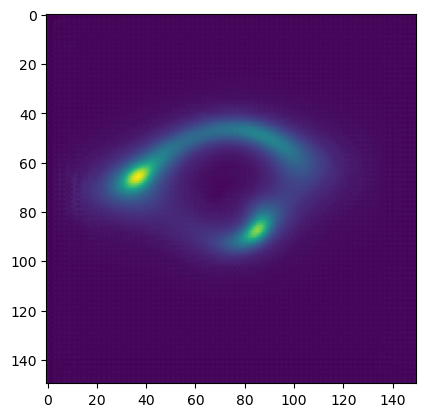

In [11]:
from keras.models import load_model
import matplotlib.pyplot as plt

# def psnr(y_true, y_pred):
#     max_pixel = 255.0
#     mse = np.mean((y_true - y_pred) ** 2)
#     return 20 * np.log10(max_pixel / np.sqrt(mse))

# # Define the SSIM function
# def ssim_metric(y_true, y_pred):
#     ssim = tf.image.ssim(y_true, y_pred, max_val=255)
#     return ssim

model = load_model('super_res_model.h5', custom_objects={'psnr': psnr, 'ssim_metric': ssim_metric})
predicted_images = model.predict_generator(val_datagen, steps=len(val_datagen))

# Display the first predicted image
plt.imshow(predicted_images[0])
plt.show()